In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input,Dense,Activation
from sklearn.cross_validation import KFold
from keras.callbacks import EarlyStopping

def load_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    return x_train, y_train, x_test, y_test
    
def perform_eda(x_train, y_train, x_test, y_test):
    print("EDA RESULTS")
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print("Min y_train value", y_train.min())
    print("Max y_train value", y_train.max())
    print("Max x_train value", x_train.max())
    s = pd.Series(y_train.flatten())
    axes = s.value_counts().sort_index().plot(kind = 'bar')
    axes.set_xlabel('Class')
    axes.set_ylabel('Prevalance')
    axes.set_title('Prevalance for Classes')
    plt.savefig('Class Imbalance.png')
    plt.show()
    print("--------------------------------------------")
    
def assign_var_dict(x_train, y_train, x_test, y_test):   
    var = {}
    var['nb_train'] = x_train.shape[0]
    var['nb_test'] = x_test.shape[0]
    var['nb_classes'] = len(np.unique(y_train))
    var['norm_x'] = x_train.max() 
    var['height'] = x_train.shape[1]
    var['width'] = x_train.shape[2]
    var['depth'] = x_train.shape[3]
    print(var)
    return var

def preprocess_data(x_train, y_train, x_test, y_test, var):
    #Feature Scaling
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= var['norm_x']
    x_test /= var['norm_x'] 
    # One-Hot Representation for labels
    y_train = to_categorical(y_train, var['nb_classes'])
    y_test = to_categorical(y_test, var['nb_classes'])    
    # Flatten for MLP
    x_train = np.reshape(x_train, [var['nb_train'],var['height']*var['width']*var['depth']])
    x_test = np.reshape(x_test, [var['nb_test'],var['height']*var['width']*var['depth']])
    return x_train, y_train, x_test, y_test

def create_model(var, lrval=0.1):
    model = Sequential()
    model.add(Dense(10,activation='softmax', input_shape = [var['height']*var['width']*var['depth']]))
    sgd = SGD(lr=lrval)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    #model.summary()
    return model

def train_and_validate_model(model, x_train, y_train, validperc = 0.3, epochval=20, batchsizeval=200):
    # Stop immediately if validation loss reduces
    earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

    history = model.fit(x_train, 
                       y_train, 
                       epochs=epochval, 
                       batch_size=batchsizeval, 
                       validation_split=validperc,
                       callbacks=[earlyStopping])
    return history

def evaluate_model(model, x_test, y_test):
    return model.evaluate(x_test, y_test)

def plot_metrics(history, i):    
    # "Accuracy"
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.xticks( range(len(history.history['acc'])))      
    plt.savefig("EpochAcc"+str(i)+".png")
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.xticks( range(len(history.history['loss']))) 
    plt.savefig("EpochLoss"+str(i)+".png")
    plt.show()
    
def plot_perf_hyperparameter(hyp_metrics):
    # "Loss"
    x_ticks_labels = list(map(itemgetter(2), hyp_metrics))
    plt.plot(list(map(itemgetter(0), hyp_metrics)))
    plt.title('Model Losses')
    plt.ylabel('loss')
    plt.xlabel('hyperparameter')  
    plt.xticks( range(len(x_ticks_labels)), x_ticks_labels )
    plt.savefig("TestLoss.png")
    plt.show()
    # "Accuracy"
    plt.plot(list(map(itemgetter(1), hyp_metrics)))
    plt.title('Model Accuracies')
    plt.ylabel('accuracy')
    plt.xlabel('hyperparameter')
    plt.xticks( range(len(x_ticks_labels)), x_ticks_labels )  
    plt.savefig("TestAcc.png")
    plt.show()
    
def main():
    hyp_metrics = []
    best_model = None
    best_acc = 0.0
    x_train, y_train, x_test, y_test = load_data()
    perform_eda(x_train, y_train, x_test, y_test)
    var = assign_var_dict(x_train, y_train, x_test, y_test) 
    x_train, y_train, x_test, y_test = preprocess_data(x_train, y_train, x_test, y_test, var)
    i = 0
    # Train for 5 data points
    for lr in [0.1, 0.2, 0.3, 0.4, 0.5]:
        i = i+1
        print("--------------------------------------------")
        print ("Hyperparameter SGD Learning Rate:", lr)
        model = None
        model = create_model(var, lr)
        history = train_and_validate_model(model, x_train, y_train)
        plot_metrics(history, i)        
        final_met = evaluate_model(model, x_test, y_test)
        final_met.append(lr)
        hyp_metrics.append(final_met)
        if best_acc < final_met[1]:
            best_model = model
            best_acc = final_met[1]
        print("Final evaluation on test holdout", final_met)

    plot_perf_hyperparameter(hyp_metrics)
    
    # serialize model to JSON
    model_json = best_model.to_json()
    with open("cifar_best.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    best_model.save_weights("cifar_best.h5")    
        
    

Using TensorFlow backend.
/Users/jaichitra.balakrishnan/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


EDA RESULTS
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Min y_train value 0
Max y_train value 9
Max x_train value 255


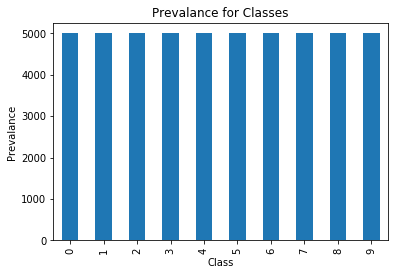

--------------------------------------------
{'nb_train': 50000, 'nb_test': 10000, 'nb_classes': 10, 'norm_x': 255, 'height': 32, 'width': 32, 'depth': 3}
--------------------------------------------
Hyperparameter SGD Learning Rate: 0.1
Train on 35000 samples, validate on 15000 samples
Epoch 1/20
35000/35000 [==============================] - 2s - loss: 0.3010 - acc: 0.9002 - val_loss: 0.2872 - val_acc: 0.9006
Epoch 2/20
35000/35000 [==============================] - 1s - loss: 0.2815 - acc: 0.9011 - val_loss: 0.2787 - val_acc: 0.9016
Epoch 3/20
35000/35000 [==============================] - 1s - loss: 0.2757 - acc: 0.9022 - val_loss: 0.2758 - val_acc: 0.9021
Epoch 4/20
35000/35000 [==============================] - 1s - loss: 0.2720 - acc: 0.9027 - val_loss: 0.2732 - val_acc: 0.9031
Epoch 5/20
35000/35000 [==============================] - 2s - loss: 0.2696 - acc: 0.9032 - val_loss: 0.2707 - val_acc: 0.9032
Epoch 6/20
35000/35000 [==============================] - 1s - loss: 0.2679 -

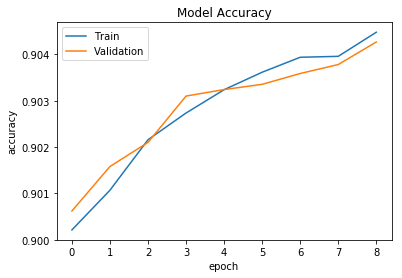

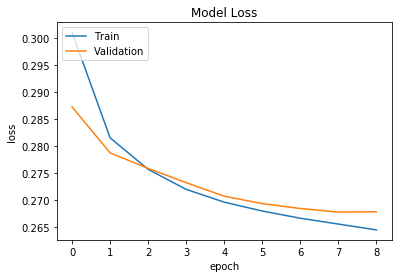

 9632/10000 [===========================>..] - ETA: 0sFinal evaluation on test holdout [0.26636183543205261, 0.90426003074646, 0.1]
--------------------------------------------
Hyperparameter SGD Learning Rate: 0.2
Train on 35000 samples, validate on 15000 samples
Epoch 1/20
35000/35000 [==============================] - 1s - loss: 0.3034 - acc: 0.9000 - val_loss: 0.3012 - val_acc: 0.9005
Epoch 2/20
35000/35000 [==============================] - 1s - loss: 0.2879 - acc: 0.9006 - val_loss: 0.2735 - val_acc: 0.9030
Epoch 3/20
35000/35000 [==============================] - 1s - loss: 0.2791 - acc: 0.9019 - val_loss: 0.2799 - val_acc: 0.9024


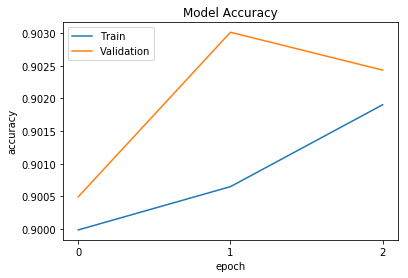

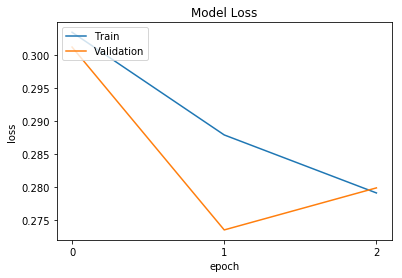

 9664/10000 [===========================>..] - ETA: 0sFinal evaluation on test holdout [0.27807750353813171, 0.90311003322601313, 0.2]
--------------------------------------------
Hyperparameter SGD Learning Rate: 0.3
Train on 35000 samples, validate on 15000 samples
Epoch 1/20
35000/35000 [==============================] - 1s - loss: 0.4142 - acc: 0.8913 - val_loss: 0.3674 - val_acc: 0.8930
Epoch 2/20
35000/35000 [==============================] - 1s - loss: 0.3617 - acc: 0.8932 - val_loss: 0.3484 - val_acc: 0.8992
Epoch 3/20
35000/35000 [==============================] - 1s - loss: 0.3639 - acc: 0.8925 - val_loss: 0.4081 - val_acc: 0.8719


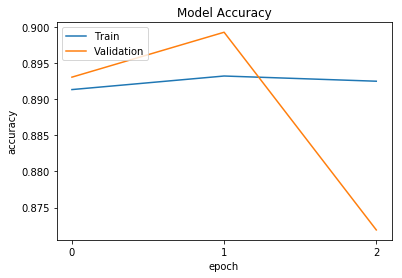

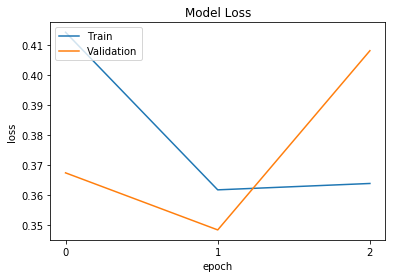

 9856/10000 [============================>.] - ETA: 0sFinal evaluation on test holdout [0.4066529103279114, 0.87247004489898683, 0.3]
--------------------------------------------
Hyperparameter SGD Learning Rate: 0.4
Train on 35000 samples, validate on 15000 samples
Epoch 1/20
35000/35000 [==============================] - 1s - loss: 2.5849 - acc: 0.8262 - val_loss: 2.8877 - val_acc: 0.8196
Epoch 2/20
35000/35000 [==============================] - 1s - loss: 2.3662 - acc: 0.8238 - val_loss: 2.6799 - val_acc: 0.8205
Epoch 3/20
35000/35000 [==============================] - 1s - loss: 2.0481 - acc: 0.8279 - val_loss: 2.8083 - val_acc: 0.8198


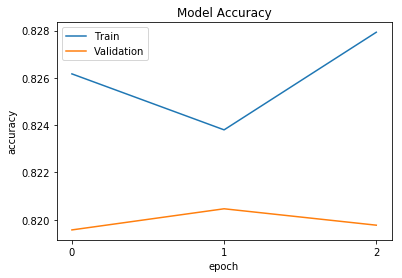

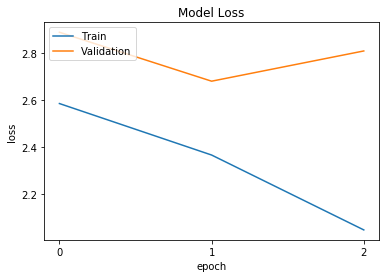

 9984/10000 [============================>.] - ETA: 0sFinal evaluation on test holdout [2.8087737941741944, 0.82010005731582647, 0.4]
--------------------------------------------
Hyperparameter SGD Learning Rate: 0.5
Train on 35000 samples, validate on 15000 samples
Epoch 1/20
35000/35000 [==============================] - 1s - loss: 2.7666 - acc: 0.8221 - val_loss: 2.8836 - val_acc: 0.8200
Epoch 2/20
35000/35000 [==============================] - 1s - loss: 2.8368 - acc: 0.8202 - val_loss: 2.8888 - val_acc: 0.8197


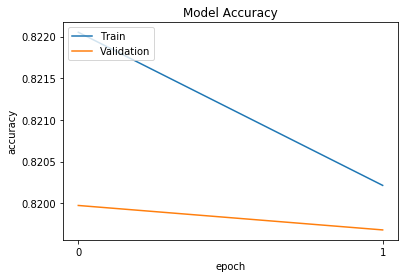

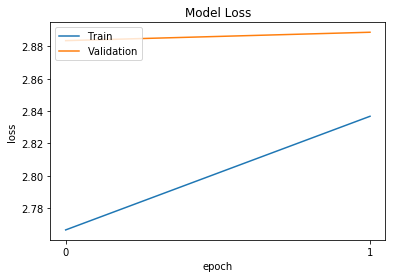

 9600/10000 [===========================>..] - ETA: 0sFinal evaluation on test holdout [2.8842786128997804, 0.82000005750656124, 0.5]


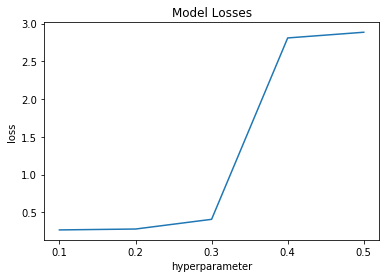

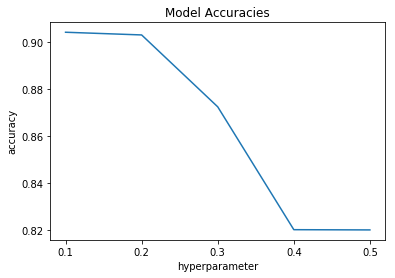

In [2]:
main()